In [ ]:
import random
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
from sklearn.manifold import MDS

In [ ]:
class AlgoritmoGenetico:
  def __init__(self, matriz, max_gen=1000, num_pais=50):
      self.matriz = matriz
      self.TAM_POPULACAO = 100
      self.MAX_GERACOES = max_gen
      self.FATOR_MUTACAO = 0.05
      self.NUM_PAIS = num_pais
      self.geracao_atual = 0

      # Armazenar a melhor solução de cada geração
      self.geracoes = []
      # Geração da população inicial
      solucoes = self.gerar_solucoes_iniciais(100, len(matriz)) # Gera 100 indivíduos de começo
      fitness = self.calcular_fitness(solucoes, matriz) # Calcula o valor de fitness para cada solução
      solucoes = [{'solucao': sol, 'fitness': fit} for sol, fit in zip(solucoes, fitness)] # Cria uma lista de dicionários com as soluções e seus respectivos fitness
      self.solucoes = sorted(solucoes, key=lambda x: x['fitness'])  # Ordena a lista de soluções com base no valor de fitness

  def gerar_solucoes_iniciais(self, k, n_cidades):
      solucoes = []
      for _ in range(k):
        cidades = list(range(n_cidades)) # Lista de todas as cidades
        solucao = []
        # Enquanto meu vetor tem elemento ele vai tirando elemento de forma aleatória e adicionando há solução
        while cidades:
          proxima_cidade = random.choice(cidades) # Escolhe aleatoriamente a próxima cidade
          cidades.remove(proxima_cidade) # Remove a cidade escolhida da lista de cidades restantes
          solucao.append(proxima_cidade) # Adiciona a cidade escolhida na solução
        solucoes.append(solucao) # Adiciona a solução na lista de soluções

      return solucoes

  def calcular_fitness(self, solucoes, matriz):
      valores_fitness = []
      # Passar por cada uma das soluções
      for solucao in solucoes:
        valor_fitness = 0
        for i in range(len(solucao)-1):
          origem = solucao[i] # Cidade de origem
          destino = solucao[i+1] # Próxima cidade no percurso
          valor_fitness = valor_fitness + matriz[origem][destino] # Adiciona o custo do deslocamento entre as cidades
        ultima_cidade = solucao[-1]
        primeira_cidade = solucao[0]
        valor_fitness = valor_fitness + matriz[ultima_cidade][primeira_cidade] # Adiciona o custo do retorno à cidade inicial
        valores_fitness.append(valor_fitness) # Adiciona o valor de fitness na lista
      return valores_fitness

  def selecionar(self, solucoes, k, n_torneio=10): # Utiliza o método de torneio
      participantes = solucoes.copy()
      selecionados = []
      # Repito a operação K vezes, sendo a quantidade de pais que quero selecionar
      while len(selecionados) < k:
        # Selecionar aleatoriamente uma quantidade de soluções igual ao tamanho do torneio
        torneio = random.sample(participantes, n_torneio) # Tirar n indivíduos (10) do meu array de participantes (soluções )

        # Ordenar as soluções do torneio pelo valor de fitness em ordem decrescente
        torneio_ordenado = sorted(torneio, key=lambda x: x['fitness'], reverse=True)

        # Retornar a solução com o maior fitness, que é o vencedor do torneio
        vencedor = torneio_ordenado[0]
        participantes.remove(vencedor) #removo o vencedor dos participantes, como ele já venceu eu não quero que ele participe novamente para evitar complicações
        selecionados.append(vencedor) # Pego o vencedor e adiciono ao vetor de selecionados

      return selecionados # No nosso cso os selecionados serão os pais

  def criar_nova_geracao(self, solucoes, n_filhos): # Se eu quero criar uma nova geração eu passo os pais e a quantidade de filhos que eu quero gerar
    novas_solucoes = []

    while len(novas_solucoes) < n_filhos: # Enqaunto eu não possuo a quantidade de filhos desejada
        # Seleciono um pai e uma mãe aleatoriamente
        sol1 = random.choice(solucoes)
        sol2 = random.choice(solucoes)

        # Escolher dois pontos de corte distintos
        ponto_corte1 = random.randint(0, len(sol1['solucao']) - 1) # Sortear um índice do meu vetor e vai separar esse meu vetor no meio
        ponto_corte2 = random.randint(0, len(sol1['solucao']) - 1)

        while ponto_corte2 == ponto_corte1: # Se os pontos de corte forem iguais eu repito
            ponto_corte2 = random.randint(0, len(sol1['solucao']) - 1)

        # Garantir que o ponto de corte 1 seja menor que o ponto de corte 2
        if ponto_corte1 > ponto_corte2:
            ponto_corte1, ponto_corte2 = ponto_corte2, ponto_corte1

        # Realizar o cruzamento das soluções
        filhos = []
        for i in range(len(sol1['solucao'])): # Iterar sobre as cidades da solução (caminho)
            #Pego uma porção das cidades do pai e adiciono ao filho
            if ponto_corte1 <= i < ponto_corte2:
                filhos.append(sol2['solucao'][i])

        # Adicionar as cidades do sol1 que não estão repetidas nos filhos
        for cidade in sol1['solucao']:
          # As que sobraram eu pego da mãe (dentro do escopo da sol1)
            if cidade not in filhos:
                filhos.append(cidade)

        # Verificar se os filhos são válidos (não possuem cidades repetidas)
        if len(filhos) == len(sol1['solucao']) and len(set(filhos)) == len(sol1['solucao']):
            novas_solucoes.append(filhos) # Se tiver alguma cidade repetida ele não adiciona o filho as soluções

    return novas_solucoes

  def aplicar_mutacao(self, solucoes, taxa_mutacao): #Mutação só nos filho (arrumar)
    solucoes_mutadas = []
    for solucao in solucoes:
      nova_solucao = solucao.copy()  # Faz uma cópia da solução original
      # para cada cidade i do caminho
      for i in range(len(nova_solucao)):
          # verifica se a mutação vai ocorrer
          if random.random() < taxa_mutacao:
              # Gera um índice aleatório correspondente a cidade j
              j = random.randint(0, len(solucao)-1)
              # Se a cidade j for igual a cidade i, sorteia novamente
              while j == i:
                j = random.randint(0, len(solucao)-1)
              # Troca as duas cidades
              aux = nova_solucao[i]
              nova_solucao[i] = nova_solucao[j]
              nova_solucao[j] = aux
      solucoes_mutadas.append(nova_solucao)
    return solucoes_mutadas

  def executar(self):
    # Ele sempre vai executar de geração em geração
    self.geracao_atual = self.geracao_atual + 1

    solucoes = self.solucoes.copy() #Pego a minha amostra de soluções
    melhor = solucoes[0] # Armazena a melhor solução
    # Seleciona os indivíduos com menores valores de distância para criar a nova geração
    pais = self.selecionar(solucoes, self.NUM_PAIS) # Pegar os pais selecionados (função)


    #Criar filhos
    filhos = self.criar_nova_geracao(pais, self.TAM_POPULACAO) # Chama (função) nova geração
    # Depois que eu já tenho os filhos criados eu faço a mutação (função)
    filhos = self.aplicar_mutacao(filhos, self.FATOR_MUTACAO)
    # Calcula o valor de distância de cada um dos filhos
    filhos_valores_fitness = self.calcular_fitness(filhos, self.matriz)
    # Setar no formato correto
    filhos = [{'solucao': sol, 'fitness': fit} for sol, fit in zip(filhos, filhos_valores_fitness)]

    solucoes = pais + filhos # Minha nova população é constituida pelos pais que eu selecionei e os filhos gerqados pelos pais
    solucoes = sorted(solucoes, key=lambda x: x['fitness'])  # Ordena a lista de soluções com base no valor de fitness
    # Pego todos os elementos até a posição TAM_POPULAÇÃO (A princípio 100 depois alterar para testes)
    solucoes = solucoes[:self.TAM_POPULACAO] # Mantém apenas as 100 melhores soluções (tamanho da população) / Isto serivrá para garantir que a cada geração eu tenha um número fixo de população

    self.geracoes.append(self.solucoes[0]) # Vetor de gerações para ele armazenar a melhor solução de cada geração

    # Garantir que o melhor individuo de todas as gerações ele perpetue na próxima geração
    # Garantir que o melhor seja perpetuado
    if melhor not in solucoes:
      solucoes.append(melhor)
    self.solucoes = solucoes # Atualizo a minha lista de soluções com as soluções dessa geração

In [ ]:
matriz = [[9999] * 10 for _ in range(10)]
matriz[0][1] = matriz[1][0] = 8
matriz[1][3] = matriz[3][1] = 12
matriz[3][4] = matriz[4][3] = 19
matriz[4][5] = matriz[5][4] = 15
matriz[5][6] = matriz[6][5] = 22
matriz[6][8] = matriz[8][6] = 21
matriz[8][9] = matriz[9][8] = 12
matriz[9][1] = matriz[1][9] = 11
matriz[1][2] = matriz[2][1] = 9
matriz[2][4] = matriz[4][2] = 13
matriz[5][2] = matriz[2][5] = 15
matriz[5][0] = matriz[0][5] = 14
matriz[8][7] = matriz[7][8] = 10
matriz[7][9] = matriz[9][7] = 8
matriz[7][5] = matriz[5][7] = 18
matriz[7][0] = matriz[0][7] = 8
matriz[0][2] = matriz[2][0] = 13

### Execução do Algoritmo Genético

In [ ]:
ag = AlgoritmoGenetico(matriz, max_gen=20000, num_pais=80) #Instanciar a classe
# Como o algoritmo genético executa geração por geração eu tenho que fazer um for para cada geração na quantidade total ele executa esse valor
for gen in range(ag.MAX_GERACOES):
  ag.executar()

# E consequentemente eu terei que ter armazenado para cada geração a melhor solução

### Gráfico de distância pelas gerações

Índice da melhor solução: 345


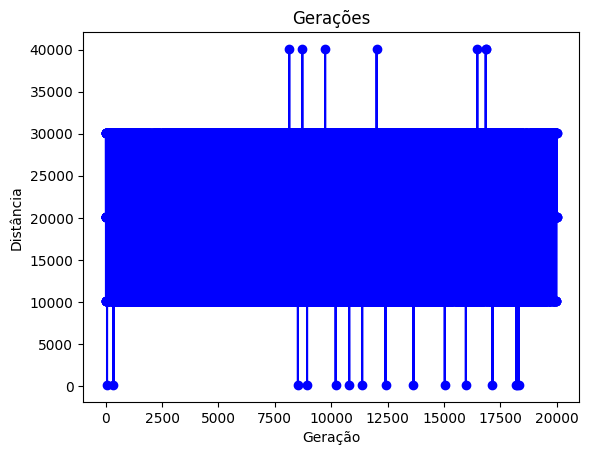

In [ ]:
fitness = [ s['fitness'] for s in ag.geracoes ]
indice_minimo = fitness.index(min(fitness)) # Pego o indice da geração com menor distancia
print('Índice da melhor solução:', indice_minimo)

# Defino os valores do eixo x e y
x = range(len(ag.geracoes))
y = [ sol['fitness'] for sol in ag.geracoes ]

plt.plot(x, y, marker='o', linestyle='-', color='b')

# Adicionar rótulos aos eixos
plt.xlabel('Geração')
plt.ylabel('Distância')

# Adicionar título ao gráfico
plt.title('Gerações')

# Exibir o gráfico
plt.show()

### Caminhos por gerações

In [ ]:
# Função para exibir a melhor solução da geração atual
def exibir_solucao(geracao):
    melhor_solucao = ag.geracoes[geracao]
    caminho = melhor_solucao['solucao']
    print('Caminho:', caminho, 'Fitness:', melhor_solucao['fitness'])

    # Plotar o grafo com o caminho destacado
    plt.clf()
    plt.title(f"Geração {geracao}")
    plt.scatter(coord_x, coord_y, color='blue', zorder=1)
    plt.plot(coord_x[caminho + [caminho[0]]], coord_y[caminho + [caminho[0]]], color='red', zorder=2)

    for i, (x, y) in enumerate(zip(coord_x, coord_y)):
        plt.text(x, y, str(i), ha='center', va='bottom')

    plt.show()

num_cidades = len(matriz)

# gera as coordenadas automaticamente de acordo com a matriz de adjacencia
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coordenadas = mds.fit_transform(matriz)
coord_x = coordenadas[:, 0]
coord_y = coordenadas[:, 1]

# Criar um controle deslizante (slider) interativo
slider_geracao = widgets.IntSlider(min=0, max=len(ag.geracoes)-1, step=1, value=0)

# Função chamada ao alterar o valor do slider
def slider_update(geracao):
    exibir_solucao(geracao)

# Registrar a função slider_update como um manipulador do evento
widgets.interact(slider_update, geracao=slider_geracao)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


interactive(children=(IntSlider(value=0, description='geracao', max=19999), Output()), _dom_classes=('widget-i…

<function __main__.slider_update(geracao)>

### ORDENADO da menor distância para a maior

In [ ]:
for i in range(len(ag.geracoes)):
  ag.geracoes[i]['i'] = i

geracoes_ordenadas = sorted(ag.geracoes, key=lambda x: x['fitness'])

# Função para exibir a melhor solução da geração atual
def exibir_solucao_ordenado(geracao):
    melhor_solucao = geracoes_ordenadas[geracao]
    caminho = melhor_solucao['solucao']
    print('Caminho:', caminho, 'Fitness:', melhor_solucao['fitness'])

    # Plotar o grafo com o caminho destacado
    plt.clf()
    plt.title(f"Geração {melhor_solucao['i']}")
    plt.scatter(coord_x, coord_y, color='blue', zorder=1)
    plt.plot(coord_x[caminho + [caminho[0]]], coord_y[caminho + [caminho[0]]], color='red', zorder=2)

    for i, (x, y) in enumerate(zip(coord_x, coord_y)):
        plt.text(x, y, str(i), ha='center', va='bottom')

    plt.show()

# Criar um controle deslizante (slider) interativo
slider_geracao_ordenada = widgets.IntSlider(min=0, max=len(ag.geracoes)-1, step=1, value=0)

# Função chamada ao alterar o valor do slider
def slider_update_ordenado(geracao):
    exibir_solucao_ordenado(geracao)

# Registrar a função slider_update como um manipulador do evento
widgets.interact(slider_update_ordenado, geracao=slider_geracao_ordenada)

interactive(children=(IntSlider(value=0, description='geracao', max=19999), Output()), _dom_classes=('widget-i…

<function __main__.slider_update_ordenado(geracao)>